In [1]:
from omegaconf import OmegaConf
from one_d_piece import OneDPiece
import torch
from PIL import Image
import numpy as np

attention mode is flash


D:\pyproject\awesome_tokenizer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\pyproject\awesome_tokenizer\One_D_tokenizer\modules\quantizer.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
D:\pyproject\awesome_tokenizer\One_D_tokenizer\modules\quantizer.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
D:\pyproject\awesome_tokenizer\One_D_tokenizer\modules\quantizer.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
D:\pyproject\awesome_tokenizer\One_D_tokenizer\modules\quantizer.py:161:

In [2]:
config = OmegaConf.load("./configs/one_d_piece_b256.yaml")

In [3]:
tokenizer = OneDPiece(config)
state_dict = torch.load("./checkpoints/one_d_B_256_tokenizer.bin", map_location="cpu")
tokenizer.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [4]:
image = Image.open("./cat.jpg").convert("RGB")
image = image.resize((256, 256), Image.LANCZOS)
image = np.array(image).astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
image.shape

torch.Size([1, 3, 256, 256])

In [5]:
tokenizer.eval()

OneDPiece(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(768, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, out_featur

In [6]:
encoded_tokens = tokenizer.encode(image)[1]["min_encoding_indices"]
encoded_tokens.shape

torch.Size([1, 1, 256])

In [7]:
reconstructed_image = tokenizer.decode_tokens(encoded_tokens, length=64)
reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
reconstructed_image = Image.fromarray(reconstructed_image)

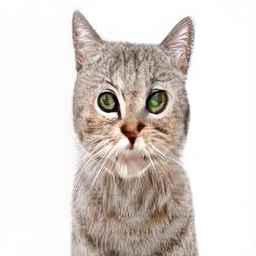

In [8]:
reconstructed_image